In [1]:
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np 

%reload_ext autoreload
%aimport fluid_flow
from fluid_flow import produce_final_data, compute_UVP
from pathlib import Path

In [2]:
#compute_UVP(30);

In [4]:
#%autoreload 1
N_list = np.array([30,50,70,100,130, 160, 200,250])
#N_list = np.array([50])

if False:
    chrono = produce_final_data(N_list)
    
    from pathlib import Path
    p = Path('data/vel_field') / 'UVP_CPU_time_2.npy'
    np.save(p, [N_list, chrono])

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
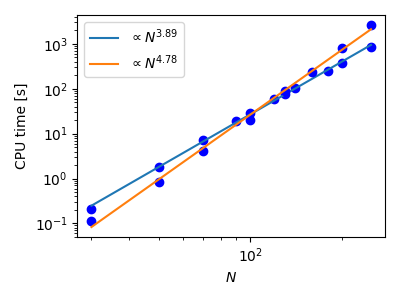

In [5]:
fig, ax = plt.subplots(figsize=(4,3))

ps = [Path('data/vel_field') / 'UVP_CPU_time{}.npy'.format(s) for s in ['', '_2']]
      
for p in ps:
    N_list, chrono = np.load(p)

    ax.plot(N_list, chrono, 'bo')
    ax.set_xscale('log')
    ax.set_yscale('log')
    from scipy.optimize import curve_fit
    def lin(x, a, b): return a*x + b 
    popt, pcov = curve_fit(lin, np.log(N_list), np.log(chrono))
    a,b = popt
    yopt = np.exp(b)*(N_list)**a
    if False:
        ax.text(0.9, 0.2, '$\delta \propto N^{' + '{:.2f}'.format(a) + '}$', 
                transform=ax.transAxes, horizontalalignment='right', verticalalignment='bottom',
                fontsize='x-large')
    s = '$\propto N^{' + '{:.2f}'.format(a) + '}$'
    ax.plot(N_list, yopt, label=s)
ax.set_xlabel('$N$')
ax.set_ylabel('CPU time [s]')
ax.legend()
plt.tight_layout()

In [6]:
print('total time needed [min]:', chrono.sum() / 60)

total time needed [min]: 63.19419091939926


Now we see the variation of N and its effects on the simulation status
1. fixing atol this time
2. measuring 3 Time for the same grid size (N) than averaging N_loop=3

In [10]:
print(dt,Nt0,Nt)
T,T0= dt*(Nt),dt*Nt0 # using the same time interval for all the measurements 
print(T,T0)

3.2000000000000005e-05 500 300
0.009600000000000001 0.016000000000000004


In [11]:
import time
N_list = [30,50,70,90,100,120,130,140,180,200,250]
# initial convergence paramater for the Poisson solver:
atol0 = 1e-4
# number of convergence measurements
N_loop = 3

# placeholders for the respective metrics
L0 = np.zeros((2,len(N_list),N_loop))
L2 = np.zeros_like(L0)
time_list = np.zeros((len(N_list),N_loop))
UVP={}
for j in range(len(N_list)):
    N, M = N_list[j],N_list[j]
    print('working on {}'.format(N))
    dx, dy, Ns_c, Nc_lw = parameters.set_resolution(N,M)
    dt = dt_fluid_flow(dx, Fo=0.3)
    
    # initial w parameter for the Poisson solver:
    w0 = 2 / (1 + sin(pi/N))

    # initial iterations before staerting the analysis
    Nt0 = int(T0/dt)

    # number of iterations between 2 convergence measurements
    Nt = int(T/dt)
    
    # initial setup of velocity field
    u0 = np.zeros((N,M))
    v0 = np.copy(u0)
    u0,v0 = set_boundary(u0,v0,Ns_c, Nc_lw)
    u, v = np.copy(u0), np.copy(v0)


    
    # initial warm-up:
    u, v, P,_ = advance_fluid_flow(Nt0, u, v, advance_adv_diff_RK3, dt)

    # convergence analysis:
    
    for i in range(N_loop):
        start= time.time()    
        w = w0 # modifying this param. doesn't yield satisfactory results
        atol = atol0 #atol is fixed
        
        u_old, v_old = np.copy(u), np.copy(v)
        u, v, P,_ = advance_fluid_flow(Nt, u, v, advance_adv_diff_RK3, dt, w=w, atol=atol, P=P)
        if i==0 :UVP[N] = np.array([u.copy(),v.copy(),P.copy()])
        # measurements:
        L0[0,j,i] = metric_L0(u_old, u)
        L0[1,j,i] = metric_L0(v_old, v) 
        
        L2[0,j,i] = metric_RMS(u_old, u)
        L2[1,j,i] = metric_RMS(v_old, v)
        time_list[j,i]= time.time() - start

working on 30
working on 50


SystemError: CPUDispatcher(<function advance_fluid_flow at 0x7f5f63a8b160>) returned a result with an error set

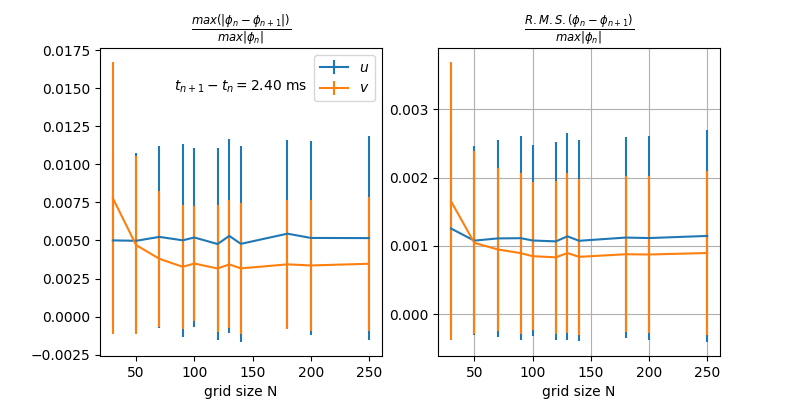

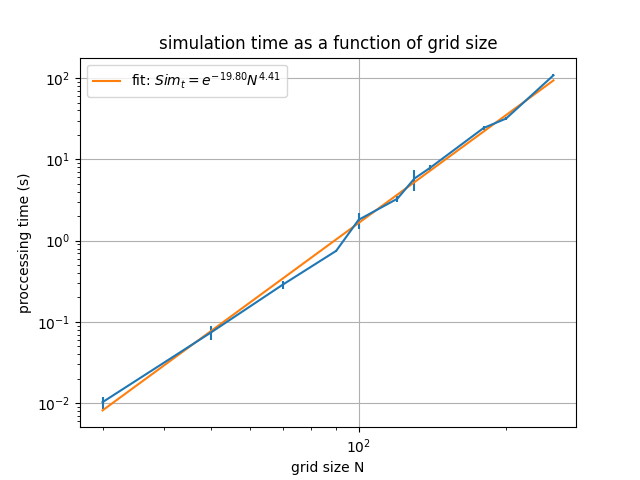

In [13]:
params = np.polyfit(np.log(N_list),np.log(np.mean(time_list[:,:],axis = 1)),deg=1)

fig, [ax, ax2] = plt.subplots(1,2, figsize=(8,4), sharex=True)
ax.errorbar(N_list, (np.mean(L0[0,:,:],axis = 1)),yerr=(np.std(L0[0,:,:],axis = 1)), label='$u$')
ax.errorbar(N_list, (np.mean(L0[1,:,:],axis = 1)),yerr=(np.std(L0[1,:,:],axis = 1)), label='$v$')

ax2.errorbar(N_list, (np.mean(L2[0,:,:],axis = 1)),yerr=(np.std(L2[0,:,:],axis = 1)), label='$u$')
ax2.errorbar(N_list, (np.mean(L2[1,:,:],axis = 1)),yerr=(np.std(L2[1,:,:],axis = 1)), label='$v$')

ax.set_xlabel('grid size N')
ax2.set_xlabel('grid size N')
ax.set_yscale ('linear')
ax2.set_yscale('linear')
ax.set_xscale ('linear')
ax2.set_xscale('linear')

ax.set_title(r'$\frac{ max ( |\phi_n - \phi_{n+1}| ) } { max |\phi_n| }$')
ax2.set_title(r'$\frac{ R.M.S.( \phi_n - \phi_{n+1} ) }{ max |\phi_n| }$')

s = r'$t_{n+1} - t_n = $' +'${:.2f}$ ms'.format(Nt * dt * 1e3)
ax.text(0.5, 0.9, s, verticalalignment='top', horizontalalignment='center', transform=ax.transAxes)
ax.legend()
plt.grid()

fig, ax = plt.subplots()
plt.errorbar(N_list,
            np.mean(time_list[:,:],axis = 1),
            yerr=np.std(time_list[:,:],axis = 1) )
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_title('simulation time as a function of grid size')
ax.set_xlabel('grid size N')
ax.set_ylabel('proccessing time (s)')
ax.plot(N_list,np.exp(params[1])*np.array(N_list)**params[0],label = r'fit: $Sim_t = e^{{ {1:5.2f} }}N^{{ {0:4.2f} }}$'.format(round(params[0],ndigits=2),round(params[1],ndigits=2)))
plt.legend()
plt.grid()



In [18]:
from pathlib import Path
print(UVP.keys())
for i in  range(len(N_list)):
    N = N_list[i]
    datap = Path('data/vel_field') / 'UVP_N{}M{}.npy'.format(N,N)
    np.save(datap, UVP[N])

dict_keys([30, 50, 70, 90, 100, 120, 130, 140, 180, 200, 250])
